# 미니 경진대회 - 선박 도장 품질 분류

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.**

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

## Library Imports

In [1]:
# # 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
# !pip install --upgrade pip
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install opencv-python
# !sudo apt-get update
# !sudo apt-get install libgl1-mesa-glx -y
# !pip install albumentations
# !pip install timm
# !pip install transformers
# !pip install wandb
# !wandb.login(key="c7e355ee28e73332b4722183a035f1a153f7b6a7")
# !pip install nbformat

In [2]:
# --- 기본 및 데이터 처리 라이브러리 ---
import os  # 운영체제와 상호작용하기 위한 라이브러리 (파일 경로 등)
import random  # 무작위 샘플링 및 시드 고정을 위해 사용
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV, 이미지 파일을 읽고 처리하기 위한 라이브러리
import math

# --- 딥러닝(PyTorch) 관련 라이브러리 ---
import torch  # PyTorch 핵심 라이브러리
import torch.nn as nn  # 신경망 모델의 레이어나 손실 함수 등을 포함
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋과 데이터 로더를 위한 클래스
import torchvision.transforms.functional as F

# --- PyTorch 최적화 및 스케줄러 ---
from torch.optim import AdamW  # Adam Optimizer의 개선된 버전, 딥러닝에서 널리 사용됨
from transformers import get_linear_schedule_with_warmup  # 학습률을 점진적으로 조정하는 스케줄러

# --- 이미지 증강 라이브러리 ---
import albumentations as A  # 빠르고 다양한 이미지 증강 기법을 제공하는 라이브러리
from albumentations.pytorch import ToTensorV2  # Albumentations 출력을 PyTorch 텐서로 변환

# --- 최신 이미지 모델 라이브러리 ---
import timm  # PyTorch Image Models, 거의 모든 최신 비전 모델을 쉽게 사용할 수 있게 해주는 라이브러리

# --- 진행 상황 시각화 ---
from tqdm.auto import tqdm  # for문 등 반복문의 진행 상황을 시각적으로 보여주는 라이브러리 (주피터 노트북용)

# --- 머신러닝 및 평가 라이브러리 ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# --- 시각화 및 한글 설정 ---
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
mpl.rc("font", family="NanumGothic") # Linux
# mpl.rc("font", family="AppleGothic") # Mac
# mpl.rc("font", family="Malgun Gothic") # Windows
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline

## Configuration

In [3]:
# 모든 하이퍼파라미터와 설정을 이곳에서 관리합니다.
CFG = {
    # --- 기본 설정 ---
    "ROOT": Path("/mnt/elice/dataset/"),
    "SEED": 42,  # 재현성을 위한 랜덤 시드
    "DEVICE": torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ),  # GPU 사용 가능 여부에 따라 디바이스 설정
    # --- 학습 파라미터 ---
    "IMG_SIZE": 224,  # 모델에 입력될 이미지의 크기 (가로, 세로)
    "EPOCHS": 20,  # 전체 데이터셋을 총 몇 번 학습할 것인지 (에폭)
    "PATIENCE":20,   # early stopping patience
    "LEARNING_RATE": 1e-4,  # 학습률. 모델이 얼마나 큰 폭으로 파라미터를 업데이트할지 결정
    "BATCH_SIZE": 16,  # 한 번의 반복(iteration)에서 모델에 입력할 데이터의 개수
    "NUM_CLASSES": 5, # 클래스 개수 설정
}

print("✅ 환경설정 완료!")
print(f"사용할 디바이스: {CFG['DEVICE']}")

✅ 환경설정 완료!
사용할 디바이스: cuda


## Utils

In [4]:
# 랜덤 시드 고정
def set_seed(seed=42):
    random.seed(seed)  # 파이썬 표준 난수 시드
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)  # Numpy 난수 시드
    torch.manual_seed(seed)  # PyTorch CPU 연산 난수 시드
    torch.cuda.manual_seed(seed)  # CUDA 단일 GPU 난수 시드
    torch.cuda.manual_seed_all(seed)  # CUDA 다중 GPU 난수 시드
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 결정론적으로 고정
    torch.backends.cudnn.benchmark = False  # 입력 크기 탐색 비활성화


set_seed(CFG["SEED"])
print(f"✅ 시드({CFG['SEED']}) 고정 완료!")

✅ 시드(42) 고정 완료!


## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

ROOT 디렉토리에는 선박 도장의 손상 정도를 파악하고 도장 품질의 검사 정확도 개선을 위한 선박 도장 상태별 이미지 데이터가 저장되어 있습니다. 데이터 이미지들은 아래와 같은 6개의 폴더에 나눠져 저장되어 있습니다.

* TS_도막 손상_도막떨어짐
* TS_도막 손상_스크래치
* TS_도장 불량_부풀음
* TS_도장 불량_이물질포함
* TS_양품_선수
* TS_양품_외판

이번 경진대회의 목표는 해당 이미지들을 활용하여 선박 도장의 손상 종류를 분류하는 것입니다. 각 폴더에 존재하는 이미지들의 라벨은 다음과 같습니다.

* TS_도막 손상_도막떨어짐 -> 도막떨어짐
* TS_도막 손상_스크래치 -> 스크래치
* TS_도장 불량_부풀음 -> 부풀음
* TS_도장 불량_이물질포함 -> 이물질포함
* TS_양품_선수 -> 양품
* TS_양품_외판 -> 양품

주의: 폴더의 경로를 찾을 수 없다는 오류 메시지가 발생하는 경우 한글 폴더 이름의 인코딩 문제일 수 있습니다. 아래 베이스라인 코드의 폴더명들을 활용하세요.

In [5]:
# 폴더명과 라벨을 매핑하는 딕셔너리
if CFG["NUM_CLASSES"] == 5:
    folder_to_label = {
        "TS_도막 손상_스크래치": "스크래치",
        "TS_도장 불량_부풀음": "부풀음",
        "TS_도막 손상_도막떨어짐": "도막떨어짐",
        "TS_도장 불량_이물질포함": "이물질포함",
        "TS_양품_선수": "양품",
        "TS_양품_외판": "양품",
    }
else:
    folder_to_label = {
        "TS_도막 손상_스크래치": "스크래치",
        "TS_도장 불량_부풀음": "부풀음",
        "TS_도막 손상_도막떨어짐": "도막떨어짐",
        "TS_도장 불량_이물질포함": "이물질포함",
        "TS_양품_선수": "양품선",  # 양품_선수, 양품_외판 클래스 따로 분리
        "TS_양품_외판": "양품외",
    }
    
# 학습/검증 데이터 이미지 파일의 경로와 라벨을 저장할 리스트를 만듬.
train_image_data = []
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 각 폴더를 순회하며 파일 경로와 라벨을 가져옴.
for folder_name, label in folder_to_label.items():
    folder_path = CFG["ROOT"] / folder_name
    # 폴더와 하위 폴더의 모든 파일을 확인하면서 확장자를 검사.
    for image_path in folder_path.rglob("*"):
        if image_path.is_file() and image_path.suffix.lower() in IMG_EXTS:  # 확장자가 IMG_EXTS에 있으면
            train_image_data.append({"path": str(image_path), "label": label})

# 리스트를 판다스 DataFrame으로 변환.
df = pd.DataFrame(train_image_data)

print(f"전체 이미지 개수 (훈련 + 검증): {len(df)}")
display(df.head())

# 테스트 데이터 이미지 경로를 저장할 리스트를 만듬.
test_image_data = []
TEST_ROOT = CFG["ROOT"] / "제출용 데이터"
for p in TEST_ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        test_image_data.append({"path": str(p)})

# 테스트 이미지 데이터를 DataFrame으로 변환.
df_test = pd.DataFrame(test_image_data)

print(f"\n전체 이미지 개수 (테스트): {len(df_test)}")
display(df_test.head())

전체 이미지 개수 (훈련 + 검증): 1200


path label
0  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_24f2ae...  스크래치
1  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_23b33b...  스크래치
2  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_20c5f1...  스크래치
3  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_34b46d...  스크래치
4  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_42fa37...  스크래치


전체 이미지 개수 (테스트): 1000


path
0  /mnt/elice/dataset/제출용 데이터/00304.jpg
1  /mnt/elice/dataset/제출용 데이터/00765.jpg
2  /mnt/elice/dataset/제출용 데이터/00013.jpg
3  /mnt/elice/dataset/제출용 데이터/00472.jpg
4  /mnt/elice/dataset/제출용 데이터/00800.jpg

## EDA

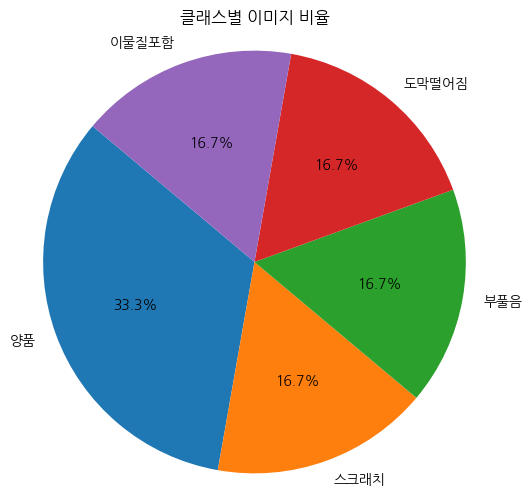

In [6]:
# 클래스별 이미지 개수 확인
plt.figure(figsize=(6,6)) 
# 파이 차트 생성
# value_counts()로 각 클래스별 개수를 얻고, index로 라벨 이름을 얻음
counts = df["label"].value_counts()
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=140)
plt.title("클래스별 이미지 비율")
plt.axis("equal")
plt.show()
# 모든 클래스 이미지 200개씩 같음

--- [ 스크래치 ] 이미지 샘플 ---


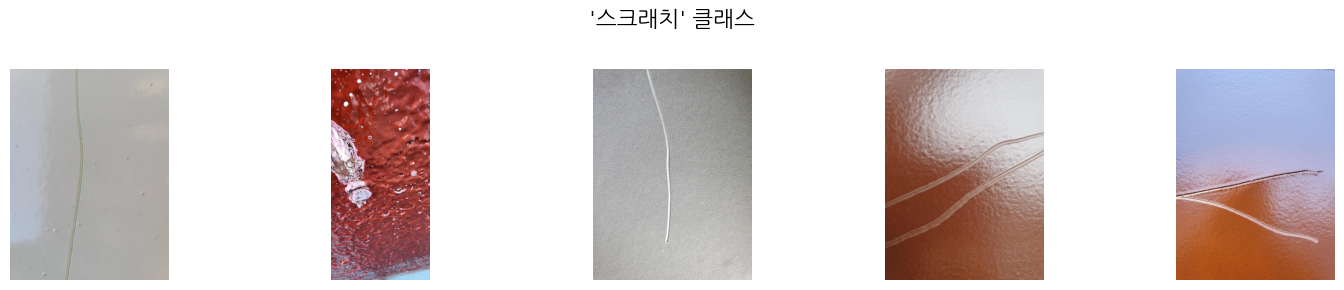



--- [ 부풀음 ] 이미지 샘플 ---


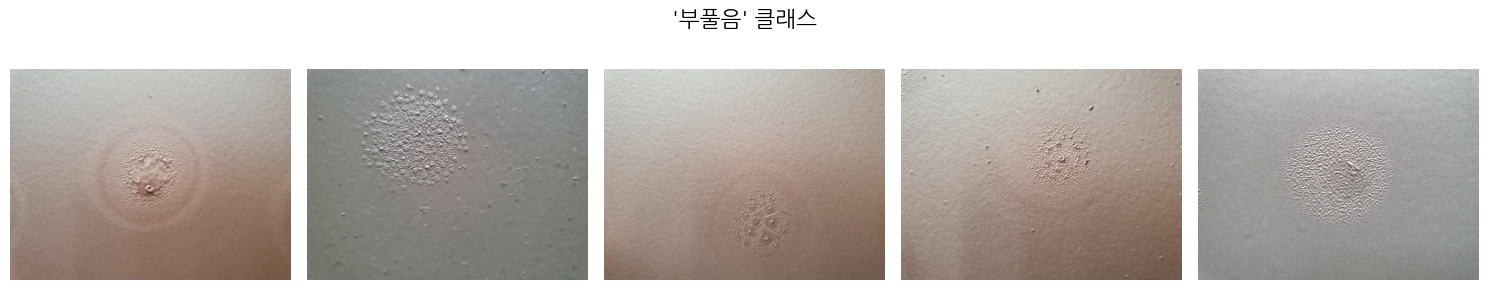



--- [ 도막떨어짐 ] 이미지 샘플 ---


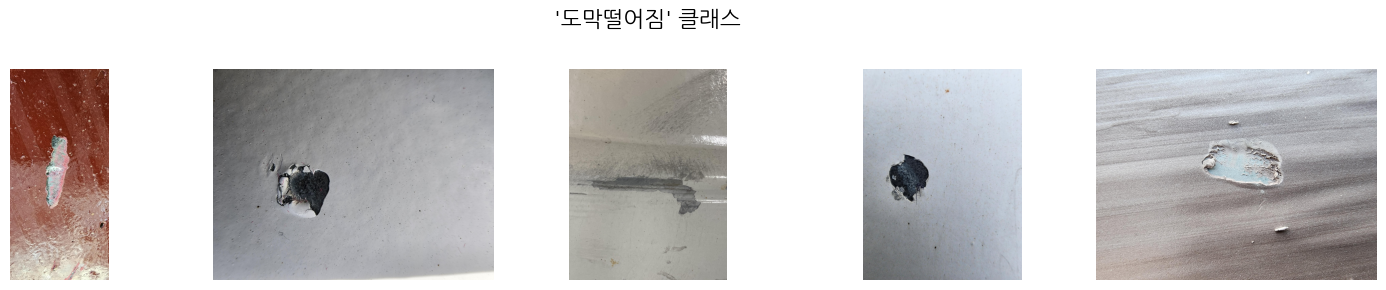



--- [ 이물질포함 ] 이미지 샘플 ---


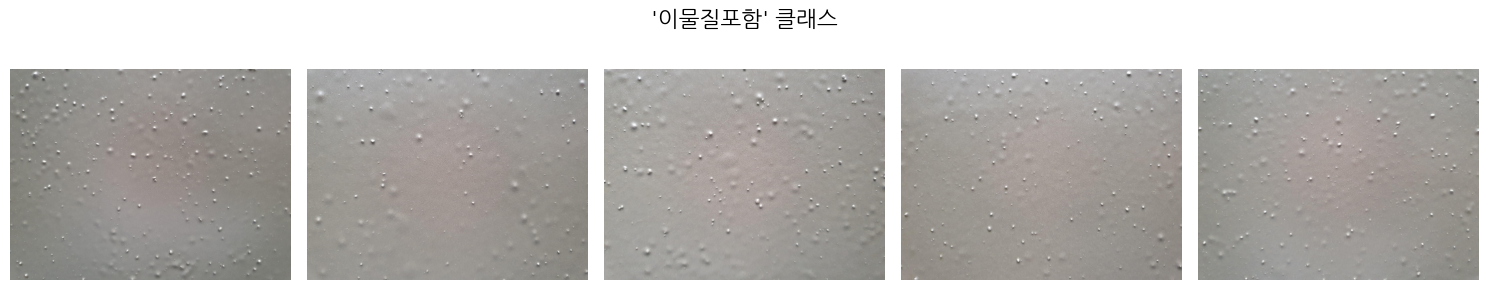



--- [ 양품 ] 이미지 샘플 ---


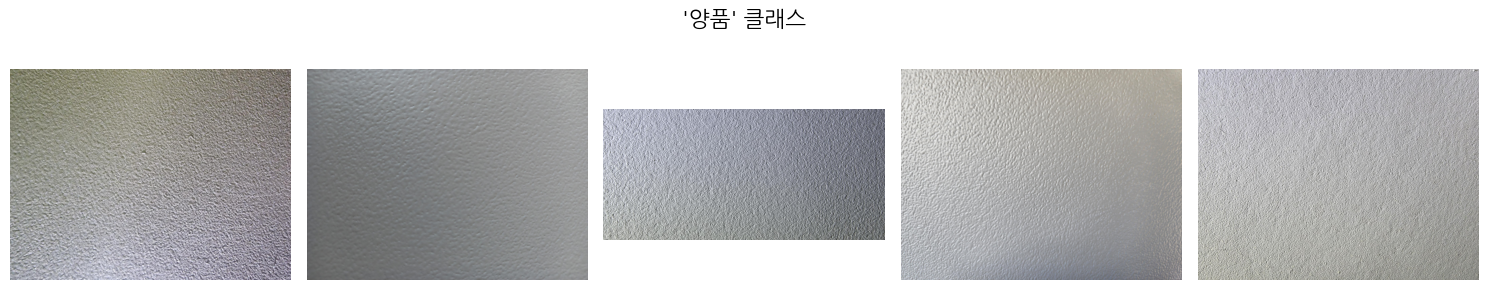



--- [ 양품 ] 이미지 샘플 ---


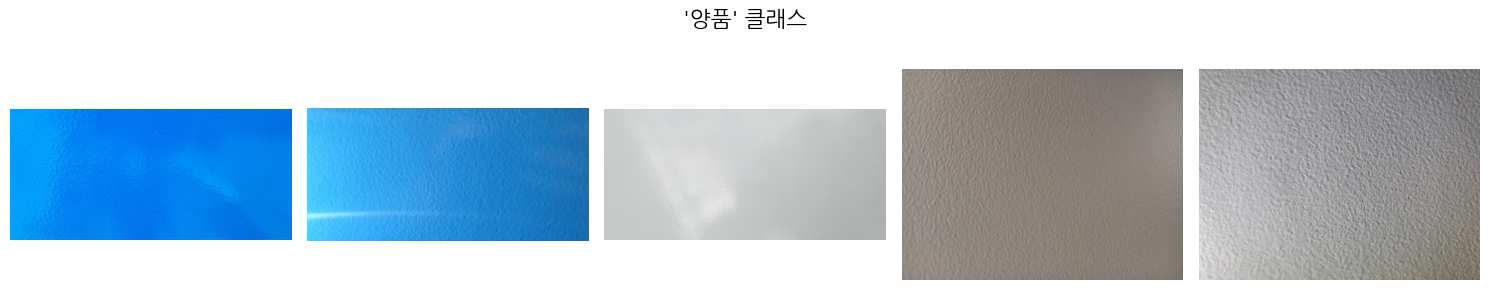

In [7]:
# 각 클래스 폴더를 돌면서 이미지 샘플을 확인.
# folder_to_label 딕셔너리의 키를 사용하여 디렉토리 경로를 구성.
for folder_name, class_name in folder_to_label.items():
    dir_path = CFG["ROOT"] / folder_name
    print(f"--- [ {class_name} ] 이미지 샘플 ---")

    # IMG_EXTS를 사용하여 모든 이미지 파일을 찾기.
    image_paths = []
    # glob으로 한 번에 여러 확장자 찾기
    for ext in IMG_EXTS:
        image_paths.extend(list(dir_path.glob(f"*{ext}")))

    # 보여줄 이미지 개수 (최대 5개)
    num_samples = min(len(image_paths), 5)

    # 이미지가 하나도 없으면 다음 폴더로
    if num_samples == 0:
        print("이미지가 없습니다.")
        continue

    # 무작위로 5개의 이미지를 선택.
    random_images = random.sample(image_paths, num_samples)

    # 1행 num_samples 열의 이미지 플롯(plot)을 생성.
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # 샘플 이미지를 하나씩 화면에 표시
    for i, img_path in enumerate(random_images):
        # 이미지 열기
        img = Image.open(img_path)

        # 해당 축(subplot)에 이미지 표시
        # 만약 axes가 단일 객체일 경우(이미지가 하나일 때)를 대비하여 조건 처리
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.axis("off")

    # 전체 플롯의 제목 설정
    fig.suptitle(f"'{class_name}' 클래스", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목과 겹치지 않도록 레이아웃 조정
    plt.show()
    print("\n")  # 클래스별 구분을 위해 줄바꿈 추가

--- [ 테스트 데이터 ] 이미지 샘플 ---


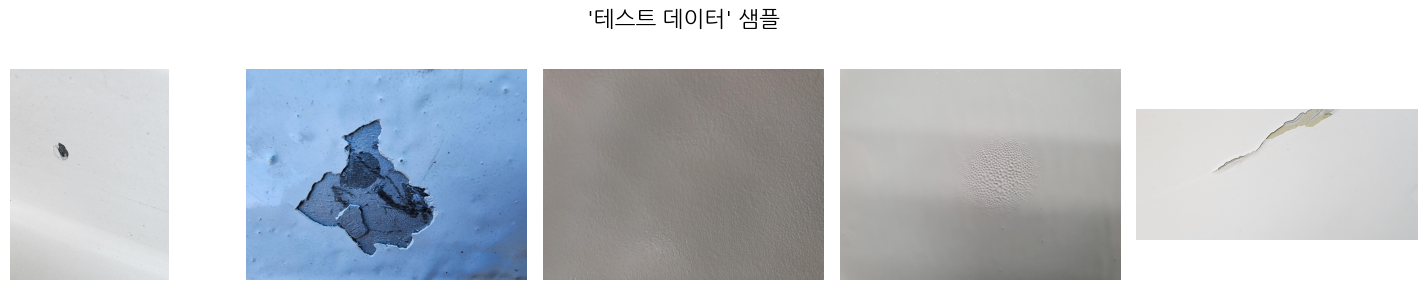

In [8]:
# df_test 데이터프레임에서 이미지 경로 리스트를 가져옴
test_image_paths = df_test['path'].tolist()

print(f"--- [ 테스트 데이터 ] 이미지 샘플 ---")

# 보여줄 이미지 개수 (최대 5개)
num_samples = min(len(test_image_paths), 5)

if num_samples == 0:
    print(" -> 테스트 데이터에 이미지가 없습니다.")
else:
    # 무작위로 이미지 선택
    random_images = random.sample(test_image_paths, num_samples)

    # 이미지 플롯 생성
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # 샘플 이미지 표시
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.axis("off")

    fig.suptitle("'테스트 데이터' 샘플", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [9]:
def get_image_properties(path):
    """이미지 경로를 받아 너비, 높이, 모드를 반환하는 함수"""
    try:
        with Image.open(path) as img:
            return img.width, img.height, img.mode
    except Exception as e:
        print(f"오류 발생: {path}, {e}")
        return None, None, None


# progress_apply를 사용하여 각 이미지의 속성을 계산하고 새 컬럼에 저장
tqdm.pandas() # 진행 상태 확인
df[["width", "height", "mode"]] = df["path"].progress_apply(
    lambda path: pd.Series(get_image_properties(path))
)

print("\n--- [훈련 데이터] 이미지 크기 통계 ---")
display(df[["width", "height"]].describe())

print("\n--- [훈련 데이터] 이미지 모드(채널) 분포 ---")
display(df["mode"].value_counts())

# progress_apply를 사용하여 테스트 이미지의 속성을 계산
df_test[["width", "height", "mode"]] = df_test["path"].progress_apply(
    lambda path: pd.Series(get_image_properties(path))
)

print("\n--- [테스트 데이터] 이미지 크기 통계 ---")
display(df_test[["width", "height"]].describe())

print("\n--- [테스트 데이터] 이미지 모드(채널) 분포 ---")
display(df_test["mode"].value_counts())


  0%|          | 0/1200 [00:00<?, ?it/s]


--- [훈련 데이터] 이미지 크기 통계 ---


width       height
count  1200.00000  1200.000000
mean   2699.88750  2212.416667
std     302.63918   372.842298
min    1272.00000  1272.000000
25%    2828.00000  2138.000000
50%    2851.00000  2138.000000
75%    2851.00000  2138.000000
max    2851.00000  2851.000000


--- [훈련 데이터] 이미지 모드(채널) 분포 ---


mode
RGB    1200
Name: count, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]


--- [테스트 데이터] 이미지 크기 통계 ---


width       height
count  1000.000000  1000.000000
mean   2621.823000  2282.643000
std     352.284334   423.084999
min    1272.000000  1272.000000
25%    2138.000000  2138.000000
50%    2851.000000  2138.000000
75%    2851.000000  2828.000000
max    2851.000000  2986.000000


--- [테스트 데이터] 이미지 모드(채널) 분포 ---


mode
RGB    1000
Name: count, dtype: int64

1. 이미지크기가 평균 2700x2200 정도의 고해상도 이미지
2. 모두 RGB

## Preprocessing

In [10]:
# 특성(X)과 라벨(y) 정의
X = df["path"]
y = df["label"]

# 훈련 데이터와 검증 데이터로 분할 (80% 훈련, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=CFG["SEED"], stratify=y
)

print(f"훈련 데이터 샘플 수: {len(X_train)}")
print(f"검증 데이터 샘플 수: {len(X_val)}")
print("\n훈련 데이터 라벨 분포:")
print(y_train.value_counts())
print("\n검증 데이터 라벨 분포:")
print(y_val.value_counts())

훈련 데이터 샘플 수: 960
검증 데이터 샘플 수: 240

훈련 데이터 라벨 분포:
label
양품       320
부풀음      160
스크래치     160
도막떨어짐    160
이물질포함    160
Name: count, dtype: int64

검증 데이터 라벨 분포:
label
양품       80
도막떨어짐    40
이물질포함    40
스크래치     40
부풀음      40
Name: count, dtype: int64


In [11]:
# --------------------------------------------------------------------------
# 1. 모든 클래스에 적용할 통합 기본 파이프라인
# --------------------------------------------------------------------------
train_transform = A.Compose(
    [
        # 이미지 크기를 224x224로 조정
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        # 50% 확률로 좌우 반전을 적용
        A.HorizontalFlip(p=0.5),
        # 50% 확률로 상하 반전을 적용. 선박 도장 결함들은 방향에 무관
        A.VerticalFlip(p=0.5),
        # 50% 확률로 90,180,270도 회전을 적용
        A.RandomRotate90(p=0.5),
        # 기하학적 변형 추가
        A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.1, rotate_limit=30),
        # 밝기, 대비, 색상 변형 추가
        A.RandomBrightnessContrast(p=0.7, brightness_limit=0.2, contrast_limit=0.2),
        A.ColorJitter(p=0.5),
        # ImageNet 평균/표준편차로 정규화를 수행.
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # 이미지를 PyTorch 텐서로 변환.
        ToTensorV2(),
    ]
)


# 검증(Validation) 데이터용 파이프라인은 그대로 유지.
val_transform = A.Compose(
    [
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [12]:
# --------------------------------------------------------------------------
# 2. 범용 Augmentation을 적용하는 표준 Custom Dataset
# --------------------------------------------------------------------------
class ShipDefectDataset(Dataset):
    """
    데이터셋 초기화
    
    Args:
        image_paths (list): 이미지 파일 경로 리스트
        labels (list): 각 이미지에 해당하는 라벨 리스트
        class_to_idx (dict): 클래스명을 인덱스로 매핑하는 딕셔너리
        transform: 이미지 변환 함수
    """
    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        인덱스에 해당하는 이미지와 라벨을 반환합니다
        
        Args:
            idx (int): 가져올 이미지의 인덱스
            
        Returns:
            tuple: (이미지, 라벨 인덱스)
        """
        # 이미지 경로와 라벨(클래스 이름) 가져오기
        image_path = self.image_paths[idx]
        # 라벨이 None인 경우(예: 테스트 데이터셋)를 처리
        class_name = self.labels[idx] if self.labels is not None else None

        # 이미지 불러오기 (OpenCV는 BGR 순서)
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 전달받은 transform이 있으면 적용
        if self.transform:
            augmented_image = self.transform(image=image)["image"]
        else:
            # transform이 없는 경우, 원본 이미지를 반환 (또는 기본 transform 적용)
            augmented_image = image

        # 라벨이 None이 아닐 경우에만 클래스 이름을 정수 인덱스로 변환
        # 라벨이 없는 경우를 나타내기 위해 -1을 사용
        label_idx = self.class_to_idx[class_name] if class_name is not None else -1 # Use -1 or some indicator for no label


        return augmented_image, torch.tensor(label_idx, dtype=torch.long)

In [13]:
# 라벨을 정수 인덱스로 매핑하는 딕셔너리 생성
# 고유한 라벨 목록을 얻고 이를 기반으로 인덱스를 할당
unique_labels = sorted(df["label"].unique())
class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
print(f"클래스-인덱스 매핑: {class_to_idx}")

클래스-인덱스 매핑: {'도막떨어짐': 0, '부풀음': 1, '스크래치': 2, '양품': 3, '이물질포함': 4}


In [14]:
# 학습용 데이터셋 생성: 통합 기본 파이프라인(train_transform) 적용
train_dataset = ShipDefectDataset(
    image_paths=X_train.tolist(),
    labels=y_train.tolist(),
    class_to_idx=class_to_idx,
    transform=train_transform,
)

# 검증용 데이터셋 생성: 증강 없는 파이프라인(val_transform) 적용
val_dataset = ShipDefectDataset(
    image_paths=X_val.tolist(),
    labels=y_val.tolist(),
    class_to_idx=class_to_idx,
    transform=val_transform,
)

In [15]:
# 데이터로드 시 병렬 처리를 위한 시드 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(CFG["SEED"])

In [16]:
# 데이터로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=True,
    num_workers=2,                      
    pin_memory=True,                  # num_workers > 0 일 때 데이터 로딩 속도를 높여 모델 훈련 효율을 개선함
    worker_init_fn=seed_worker,   # 각 워커가 독립적이면서도 예측 가능한 무작위성을 갖게 되어, 데이터 증강 결과가 실행마다 동일하게 재현되도록 함
    generator=g,                            # 매 실행마다 똑같은 데이터 로딩 순서를 보장
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g,
)

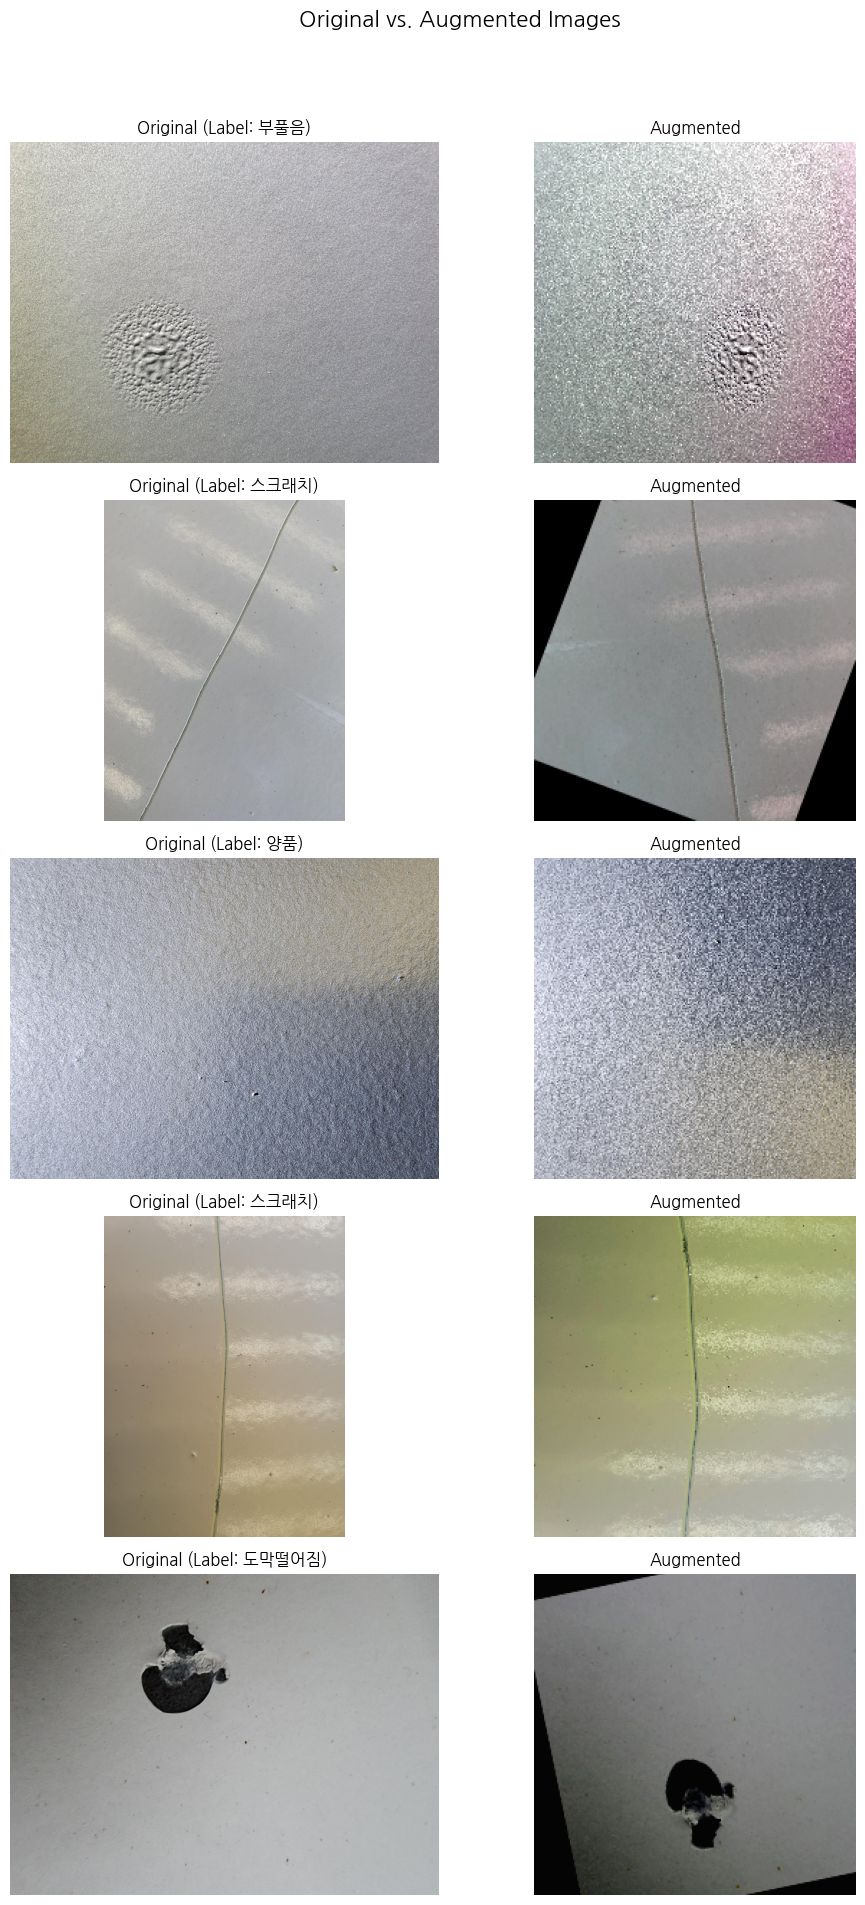

In [17]:
def visualize_augmentation(dataset, idx=0, samples=5):
    """
    데이터 증강 결과를 시각화합니다
    
    Args:
        dataset: 증강이 적용된 데이터셋
        idx (int): 시각화할 이미지의 인덱스
        samples (int): 보여줄 증강 샘플 수
    """
    
    fig, axes = plt.subplots(samples, 2, figsize=(10, 4 * samples))
    fig.suptitle("Original vs. Augmented Images", fontsize=16)

    for i in range(samples):
        # 원본 이미지를 로드하기 위해 dataset.image_paths 사용
        original_img_path = dataset.image_paths[idx + i]
        original_img = cv2.imread(original_img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # 증강된 이미지와 라벨 가져오기 (Dataset의 __getitem__ 사용)
        augmented_img, label_idx = dataset[idx + i]
        label_name = list(dataset.class_to_idx.keys())[
            list(dataset.class_to_idx.values()).index(label_idx)
        ]

        # Matplotlib으로 시각화하기 위해 역정규화(denormalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # 텐서 차원 변경 (C, H, W) -> (H, W, C)
        augmented_img_np = augmented_img.permute(1, 2, 0).numpy()
        augmented_img_np = std * augmented_img_np + mean
        augmented_img_np = np.clip(
            augmented_img_np, 0, 1
        )  # 픽셀 값을 [0, 1] 범위로 클립

        # 원본 이미지 표시
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original (Label: {label_name})")
        axes[i, 0].axis("off")

        # 증강된 이미지 표시
        axes[i, 1].imshow(augmented_img_np)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 시각화 실행 ---
visualize_augmentation(train_dataset, idx=0, samples=5)

## 모델 학습

In [18]:
class EarlyStopping:
    """
    조기 종료(Early Stopping)를 위한 클래스
    검증 성능이 개선되지 않을 때 학습을 중단합니다
    """
    
    def __init__(self, patience=5, verbose=True, path="best_model_earlystop.pth"):
        """
        초기화
        
        Args:
            patience (int): 성능 개선을 기다릴 에폭 수
            verbose (bool): 로그 출력 여부
            path (str): 최고 성능 모델 저장 경로
        """

        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, f1_score, model):
        """
        검증 성능을 확인하고 조기 종료 여부를 결정합니다
        
        Args:
            f1_score (float): 현재 검증 F1 점수
            model: 현재 모델
            
        Returns:
            bool: 학습을 중단해야 하는지 여부
        """
        score = f1_score

        if self.best_score is None:
            self.best_score = score
            self._save_checkpoint(model)
        elif score <= self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"🔁 EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self._save_checkpoint(model)
            self.counter = 0

    def _save_checkpoint(self, model):
        """
        최고 성능 모델을 저장합니다
        
        Args:
            model: 저장할 모델
        """
        if self.verbose:
            print(f"F1 score improved. Saving model to {self.path}")
        torch.save(model.state_dict(), self.path)

In [19]:
# 모델 훈련 함수 정의
def train(model, optimizer, scheduler, train_loader, val_loader, device, early_stopping):
    """
    모델 학습을 수행하는 함수
    
    Args:
        model: 학습할 모델
        optimizer: 최적화 알고리즘
        scheduler: 학습률 스케줄러
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        device: 학습 디바이스 (CPU/GPU)
        early_stopping: 조기 종료 객체
        
    Returns:
        dict: 학습 결과 정보
    """
    
    model.to(device)
    # 손실 함수 정의
    criterion = nn.CrossEntropyLoss().to(device)

    # 최고 성능 저장을 위한 변수 초기화
    best_macro_f1 = 0.0
    # 오분류 샘플 저장을 위한 리스트 초기화
    best_incorrect_samples = []

    # 훈련 메트릭스 기록을 위한 history 딕셔너리 초기화
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_macro_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_macro_f1': []
    }
    
    # 체크포인트 저장 경로 설정 및 디렉토리 생성
    model_class_name = model.__class__.__name__
    checkpoint_dir = Path(f"./checkpoints/{model_class_name}")
    checkpoint_interval = 10 # 10 에폭마다 체크포인트 저장
    checkpoint_dir.mkdir(exist_ok=True, parents=True)

    print("======== Training Start ========")
    # 설정된 에폭 수만큼 훈련 반복
    for epoch in range(CFG["EPOCHS"]):

        # --- 1. 훈련 단계 ---
        model.train() # 모델을 훈련 모드로 설정
        train_loss = 0.0 # 에폭별 훈련 손실 초기화
        all_train_preds = [] # history 기록을 위한 저장 리스트
        all_train_labels = []
        
        # 훈련 데이터 로더를 순회하며 배치 학습
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG['EPOCHS']} Training"):
            # 데이터를 지정된 디바이스로 이동
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # 이전 스텝의 기울기 초기화
            outputs = model(images) # 모델에 이미지 입력하여 예측 (순전파)
            loss = criterion(outputs, labels) # 예측값과 실제 라벨 비교하여 손실 계산
            loss.backward() # 역전파: 손실에 대한 기울기 계산
            optimizer.step() # 옵티마이저 스텝: 모델 파라미터 업데이트

            train_loss += loss.item() # 배치 손실을 누적
            
            # history 기록을 위한 예측값, 실제값 저장
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy()) 
            all_train_labels.extend(labels.cpu().numpy())
            
        avg_train_loss = train_loss / len(train_loader) # 평균 훈련 손실 계산
        train_accuracy = (np.array(all_train_preds) == np.array(all_train_labels)).mean() # 훈련 정확도 계산
        train_macro_f1 = f1_score(all_train_labels, all_train_preds, average='macro') # F1 스코어  계산
        
        # train history 저장
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_macro_f1'].append(train_macro_f1)
        
        # --- 2. 검증 단계 ---
        # 검증 함수 호출하여 검증 손실, 정확도, F1 스코어, 오분류 샘플 계산
        avg_val_loss, val_accuracy, macro_f1, incorrect_samples  = validation(model, criterion, val_loader, device)

        # validation history 저장
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_macro_f1'].append(macro_f1)
        
        # 스케줄러가 정의되어 있으면 학습률 조정
        if scheduler is not None:
            scheduler.step(avg_val_loss) # 검증 손실을 기준으로 스케줄러 스텝

        # --- 3. 결과 출력 ---
        print(f"Epoch {epoch+1}/{CFG['EPOCHS']}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Macro F1: {train_macro_f1:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Macro F1: {macro_f1:.4f}")
        # ⭐ 핵심 수정 부분: Macro F1이 최고 점수를 갱신할 때,
        # 틀린 예측 샘플 리스트(incorrect_samples)를 best_incorrect_samples에 저장합니다.
        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_incorrect_samples = incorrect_samples
            print(f"  >> New best model found! Macro F1: {macro_f1:.4f}. Updating incorrect samples list.")
       
        # EarlyStopping 객체 호출하여 Early Stopping 여부 판단 및 모델 저장
        early_stopping(macro_f1, model)

        # Early Stopping 조건 충족 시 훈련 중단
        if early_stopping.early_stop:
            print("Early Stopping!!")
            break

        # --- 4. 주기적 체크포인트 저장  ---
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pth"
            print(f"  >> Saving checkpoint at epoch {epoch+1} to {checkpoint_path}...")
            # 현재 에폭, 모델 상태, 옵티마이저 상태 등을 체크포인트 파일로 저장
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_macro_f1': best_macro_f1, # 체크포인트 저장 시점의 최고 F1 스코어 (선택 사항)
                'history': history,
            }, checkpoint_path)

    print(f"======== Training Finished ========")
    # Early Stopping으로 중단된 경우, 최고 성능 모델의 가중치를 다시 로드
    print(f"Loading best model weights from: {early_stopping.path}")
    model.load_state_dict(torch.load(early_stopping.path))

    # 훈련 완료 후, 최고 성능 모델과 오분류 샘플 리스트 반환
    return model, best_incorrect_samples, history

In [20]:
# 모델 검증 함수 정의
def validation(model, criterion, val_loader, device):
    """
    모델 검증을 수행하는 함수
    
    Args:
        model: 검증할 모델
        criterion: 손실 함수
        val_loader: 검증 데이터 로더
        device: 검증 디바이스
        
    Returns:
        tuple: (평균 손실, 예측값, 실제값)
    """
    
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    # 틀린 예측을 저장하기 위한 리스트 
    incorrect_samples = []
    
    # 기울기 계산 비활성화
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            
            # 예측이 틀린 샘플 찾기
            incorrect_mask = preds != labels
            if incorrect_mask.any():
                # 틀린 이미지, 실제 라벨, 예측 라벨을 cpu로 옮겨 저장
                for img, true, pred in zip(images[incorrect_mask], labels[incorrect_mask], preds[incorrect_mask]):
                    incorrect_samples.append({
                        'image': img.cpu(),
                        'true_label': true.cpu().item(),
                        'pred_label': pred.cpu().item()
                    })
                    
            val_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 평균 손실, 정확도, 매크로 F1 스코어 계산
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_val_loss, val_accuracy, macro_f1, incorrect_samples

In [21]:
# history 기록을 시각화하는 코드
def visualize_history(history):
    """
    훈련 및 검증 메트릭스 기록을 시각화합니다.
    손실, 정확도, F1 스코어를 각각 별도의 그래프로 표시합니다.

    Args:
        history (dict): 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy',
                        'train_macro_f1', 'val_macro_f1' 리스트를 포함하는 딕셔너리.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # 1. 손실(Loss) 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], 'o-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. 정확도(Accuracy) 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_accuracy'], 'o-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'o-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. 매크로 F1 스코어 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_macro_f1'], 'o-', label='Training Macro F1')
    plt.plot(epochs, history['val_macro_f1'], 'o-', label='Validation Macro F1')
    plt.title('Training and Validation Macro F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

| 모델명 (timm) | 아키텍처 | 파라미터 수 | 사전 훈련 데이터셋 | 특징 |
| :--- | :--- | :--- | :--- | :--- |
| `regnety_120.sw_in12k_ft_in1k` | **RegNetY** (CNN) | 약 120M | ImageNet-12k | 설계 공간(Design Space) 개념, 효율적인 구조, Squeeze-and-Excitation |
| `tiny_vit_21m_384.dist_in22k_ft_in1k` | **Tiny-ViT** (Transformer) | 약 21M | ImageNet-22k | Vision Transformer, 지식 증류(Distillation), 경량화 |
| `tf_efficientnetv2_s.in21k_ft_in1k` | **EfficientNetV2-S** (CNN) | 약 21M | ImageNet-21k | Fused-MBConv, 점진적 학습(Progressive Learning), 훈련 속도 개선 |

In [22]:
early_stopping = EarlyStopping(patience=CFG["PATIENCE"], verbose=True, path="regnety_120.pth")
# model 정의
model = timm.create_model(
    "hf_hub:timm/regnety_120.sw_in12k_ft_in1k",
    pretrained=True,
    num_classes=CFG["NUM_CLASSES"],
)
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8)

trained_model, best_incorrect_samples, history = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=CFG['DEVICE'],
    early_stopping=early_stopping
)

======== Training Start ========


Epoch 1/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/20
  Train Loss: 0.5176, Train Accuracy: 0.8385, Train Macro F1: 0.8311
  Val Loss: 0.1266, Val Accuracy: 0.9625, Val Macro F1: 0.9607
  >> New best model found! Macro F1: 0.9607. Updating incorrect samples list.
F1 score improved. Saving model to regnety_120.pth


Epoch 2/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/20
  Train Loss: 0.1406, Train Accuracy: 0.9490, Train Macro F1: 0.9444
  Val Loss: 0.0386, Val Accuracy: 0.9833, Val Macro F1: 0.9811
  >> New best model found! Macro F1: 0.9811. Updating incorrect samples list.
F1 score improved. Saving model to regnety_120.pth


Epoch 3/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/20
  Train Loss: 0.0969, Train Accuracy: 0.9688, Train Macro F1: 0.9667
  Val Loss: 0.1130, Val Accuracy: 0.9667, Val Macro F1: 0.9648
🔁 EarlyStopping counter: 1 / 20


Epoch 4/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:   Fil

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/20
  Train Loss: 0.0612, Train Accuracy: 0.9812, Train Macro F1: 0.9800
  Val Loss: 0.0686, Val Accuracy: 0.9875, Val Macro F1: 0.9863
  >> New best model found! Macro F1: 0.9863. Updating incorrect samples list.
F1 score improved. Saving model to regnety_120.pth


Epoch 5/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/20
  Train Loss: 0.0475, Train Accuracy: 0.9875, Train Macro F1: 0.9872
  Val Loss: 0.0620, Val Accuracy: 0.9875, Val Macro F1: 0.9863
🔁 EarlyStopping counter: 1 / 20


Epoch 6/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_work

Epoch 6/20
  Train Loss: 0.0658, Train Accuracy: 0.9781, Train Macro F1: 0.9759
  Val Loss: 0.0313, Val Accuracy: 0.9917, Val Macro F1: 0.9913
  >> New best model found! Macro F1: 0.9913. Updating incorrect samples list.
F1 score improved. Saving model to regnety_120.pth


Epoch 7/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/20
  Train Loss: 0.0330, Train Accuracy: 0.9906, Train Macro F1: 0.9909
  Val Loss: 0.0443, Val Accuracy: 0.9833, Val Macro F1: 0.9823
🔁 EarlyStopping counter: 1 / 20


Epoch 8/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/20
  Train Loss: 0.0284, Train Accuracy: 0.9885, Train Macro F1: 0.9878
  Val Loss: 0.0290, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 2 / 20


Epoch 9/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/20
  Train Loss: 0.0220, Train Accuracy: 0.9948, Train Macro F1: 0.9950
  Val Loss: 0.0383, Val Accuracy: 0.9833, Val Macro F1: 0.9824
🔁 EarlyStopping counter: 3 / 20


Epoch 10/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/20
  Train Loss: 0.0289, Train Accuracy: 0.9938, Train Macro F1: 0.9937
  Val Loss: 0.0210, Val Accuracy: 0.9917, Val Macro F1: 0.9912
🔁 EarlyStopping counter: 4 / 20
  >> Saving checkpoint at epoch 10 to checkpoints/RegNet/checkpoint_epoch_10.pth...


Epoch 11/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/20
  Train Loss: 0.0286, Train Accuracy: 0.9917, Train Macro F1: 0.9922
  Val Loss: 0.0114, Val Accuracy: 0.9958, Val Macro F1: 0.9950
  >> New best model found! Macro F1: 0.9950. Updating incorrect samples list.
F1 score improved. Saving model to regnety_120.pth


Epoch 12/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/20
  Train Loss: 0.0108, Train Accuracy: 0.9969, Train Macro F1: 0.9966
  Val Loss: 0.0114, Val Accuracy: 0.9958, Val Macro F1: 0.9963
  >> New best model found! Macro F1: 0.9963. Updating incorrect samples list.
F1 score improved. Saving model to regnety_120.pth


Epoch 13/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/20
  Train Loss: 0.0057, Train Accuracy: 0.9990, Train Macro F1: 0.9987
  Val Loss: 0.0115, Val Accuracy: 0.9958, Val Macro F1: 0.9963
🔁 EarlyStopping counter: 1 / 20


Epoch 14/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_work

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/20
  Train Loss: 0.0130, Train Accuracy: 0.9969, Train Macro F1: 0.9972
  Val Loss: 0.0087, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 2 / 20


Epoch 15/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/20
  Train Loss: 0.0108, Train Accuracy: 0.9969, Train Macro F1: 0.9966
  Val Loss: 0.0105, Val Accuracy: 0.9917, Val Macro F1: 0.9913
🔁 EarlyStopping counter: 3 / 20


Epoch 16/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/20
  Train Loss: 0.0110, Train Accuracy: 0.9969, Train Macro F1: 0.9972
  Val Loss: 0.0133, Val Accuracy: 0.9917, Val Macro F1: 0.9913
🔁 EarlyStopping counter: 4 / 20


Epoch 17/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/20
  Train Loss: 0.0084, Train Accuracy: 0.9979, Train Macro F1: 0.9975
  Val Loss: 0.0115, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 5 / 20


Epoch 18/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2dc033dd80>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_work

    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/20
  Train Loss: 0.0066, Train Accuracy: 0.9979, Train Macro F1: 0.9978
  Val Loss: 0.0100, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 6 / 20


Epoch 19/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/20
  Train Loss: 0.0058, Train Accuracy: 0.9990, Train Macro F1: 0.9987
  Val Loss: 0.0117, Val Accuracy: 0.9917, Val Macro F1: 0.9913
🔁 EarlyStopping counter: 7 / 20


Epoch 20/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/20
  Train Loss: 0.0058, Train Accuracy: 0.9979, Train Macro F1: 0.9975
  Val Loss: 0.0135, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 8 / 20
  >> Saving checkpoint at epoch 20 to checkpoints/RegNet/checkpoint_epoch_20.pth...
======== Training Finished ========
Loading best model weights from: regnety_120.pth


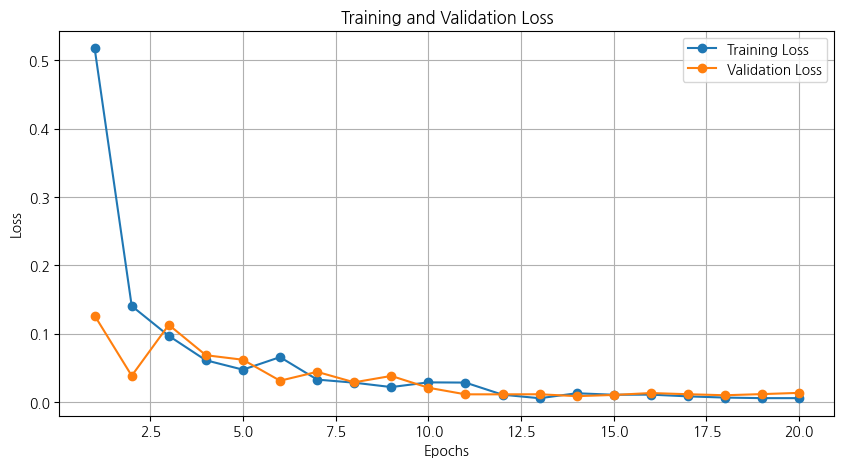

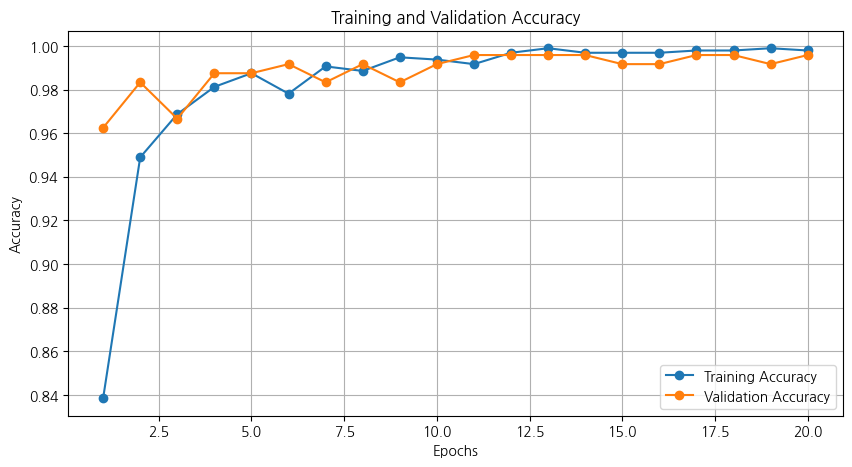

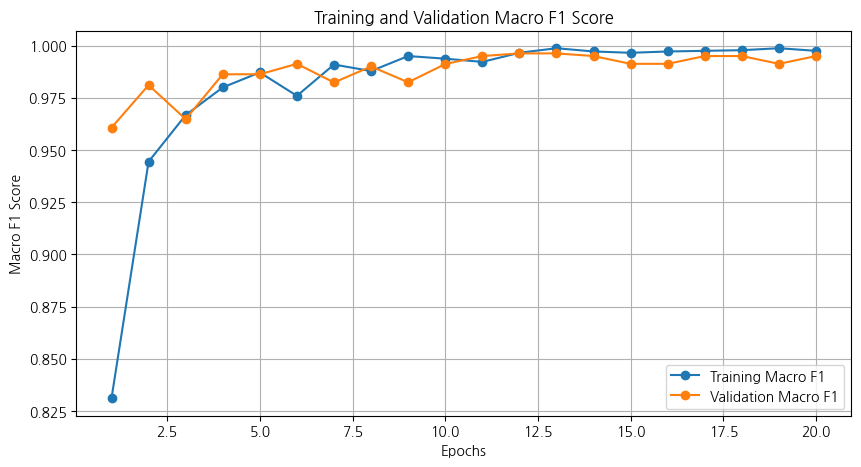

In [23]:
visualize_history(history)

In [22]:
# OOM 방지를 위해 캐시된(cached) 메모리를 해제
torch.cuda.empty_cache()

In [23]:
early_stopping = EarlyStopping(patience=CFG["PATIENCE"], verbose=True, path="tiny_vit384.pth")
# model 정의
model = timm.create_model(
    "hf_hub:timm/tiny_vit_21m_384.dist_in22k_ft_in1k",
    pretrained=True,
    num_classes=CFG["NUM_CLASSES"],
)

optimizer = torch.optim.AdamW(params = model.parameters(), 
                              lr = CFG["LEARNING_RATE"], 
                              weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='max', 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       threshold_mode='abs', 
                                                       min_lr=1e-8)

trained_model2, best_incorrect_samples2, history2 = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=CFG['DEVICE'],
    early_stopping=early_stopping
)

======== Training Start ========


Epoch 1/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/20
  Train Loss: 1.2484, Train Accuracy: 0.6396, Train Macro F1: 0.6147
  Val Loss: 0.6122, Val Accuracy: 0.9750, Val Macro F1: 0.9723
  >> New best model found! Macro F1: 0.9723. Updating incorrect samples list.
F1 score improved. Saving model to tiny_vit384.pth


Epoch 2/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/20
  Train Loss: 0.5053, Train Accuracy: 0.9375, Train Macro F1: 0.9332
  Val Loss: 0.1679, Val Accuracy: 0.9833, Val Macro F1: 0.9813
  >> New best model found! Macro F1: 0.9813. Updating incorrect samples list.
F1 score improved. Saving model to tiny_vit384.pth


Epoch 3/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    
Traceback (most recent call last):
  File "/home/elic

Epoch 3/20
  Train Loss: 0.2204, Train Accuracy: 0.9656, Train Macro F1: 0.9618
  Val Loss: 0.0857, Val Accuracy: 0.9875, Val Macro F1: 0.9876
  >> New best model found! Macro F1: 0.9876. Updating incorrect samples list.
F1 score improved. Saving model to tiny_vit384.pth


Epoch 4/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/20
  Train Loss: 0.1442, Train Accuracy: 0.9750, Train Macro F1: 0.9725
  Val Loss: 0.0484, Val Accuracy: 0.9958, Val Macro F1: 0.9950
  >> New best model found! Macro F1: 0.9950. Updating incorrect samples list.
F1 score improved. Saving model to tiny_vit384.pth


Epoch 5/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/20
  Train Loss: 0.1107, Train Accuracy: 0.9792, Train Macro F1: 0.9776
  Val Loss: 0.0500, Val Accuracy: 0.9917, Val Macro F1: 0.9912
🔁 EarlyStopping counter: 1 / 20


Epoch 6/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_work

Epoch 6/20
  Train Loss: 0.0929, Train Accuracy: 0.9823, Train Macro F1: 0.9806
  Val Loss: 0.0489, Val Accuracy: 0.9917, Val Macro F1: 0.9913
🔁 EarlyStopping counter: 2 / 20


Epoch 7/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/20
  Train Loss: 0.0762, Train Accuracy: 0.9844, Train Macro F1: 0.9825
  Val Loss: 0.0391, Val Accuracy: 0.9875, Val Macro F1: 0.9850
🔁 EarlyStopping counter: 3 / 20


Epoch 8/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/20
  Train Loss: 0.0796, Train Accuracy: 0.9844, Train Macro F1: 0.9834
  Val Loss: 0.0356, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 4 / 20


Epoch 9/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/20
  Train Loss: 0.0549, Train Accuracy: 0.9927, Train Macro F1: 0.9925
  Val Loss: 0.0353, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 5 / 20


Epoch 10/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/20
  Train Loss: 0.0590, Train Accuracy: 0.9896, Train Macro F1: 0.9887
  Val Loss: 0.0344, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 6 / 20
  >> Saving checkpoint at epoch 10 to checkpoints/TinyVit/checkpoint_epoch_10.pth...


Epoch 11/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/20
  Train Loss: 0.0600, Train Accuracy: 0.9896, Train Macro F1: 0.9885
  Val Loss: 0.0327, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 7 / 20


Epoch 12/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/20
  Train Loss: 0.0470, Train Accuracy: 0.9938, Train Macro F1: 0.9934
  Val Loss: 0.0312, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 8 / 20


Epoch 13/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/20
  Train Loss: 0.0477, Train Accuracy: 0.9896, Train Macro F1: 0.9881
  Val Loss: 0.0301, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 9 / 20


Epoch 14/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/20
  Train Loss: 0.0534, Train Accuracy: 0.9917, Train Macro F1: 0.9916
  Val Loss: 0.0315, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 10 / 20


Epoch 15/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/20
  Train Loss: 0.0509, Train Accuracy: 0.9896, Train Macro F1: 0.9878
  Val Loss: 0.0334, Val Accuracy: 0.9917, Val Macro F1: 0.9913
🔁 EarlyStopping counter: 11 / 20


Epoch 16/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/20
  Train Loss: 0.0449, Train Accuracy: 0.9938, Train Macro F1: 0.9934
  Val Loss: 0.0301, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 12 / 20


Epoch 17/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_work

    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5e8121ea0>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Excep

Epoch 17/20
  Train Loss: 0.0544, Train Accuracy: 0.9896, Train Macro F1: 0.9885
  Val Loss: 0.0323, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 13 / 20


Epoch 18/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/20
  Train Loss: 0.0437, Train Accuracy: 0.9896, Train Macro F1: 0.9884
  Val Loss: 0.0295, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 14 / 20


Epoch 19/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/20
  Train Loss: 0.0422, Train Accuracy: 0.9938, Train Macro F1: 0.9931
  Val Loss: 0.0319, Val Accuracy: 0.9917, Val Macro F1: 0.9900
🔁 EarlyStopping counter: 15 / 20


Epoch 20/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/20
  Train Loss: 0.0401, Train Accuracy: 0.9958, Train Macro F1: 0.9959
  Val Loss: 0.0287, Val Accuracy: 0.9958, Val Macro F1: 0.9950
🔁 EarlyStopping counter: 16 / 20
  >> Saving checkpoint at epoch 20 to checkpoints/TinyVit/checkpoint_epoch_20.pth...
======== Training Finished ========
Loading best model weights from: tiny_vit384.pth


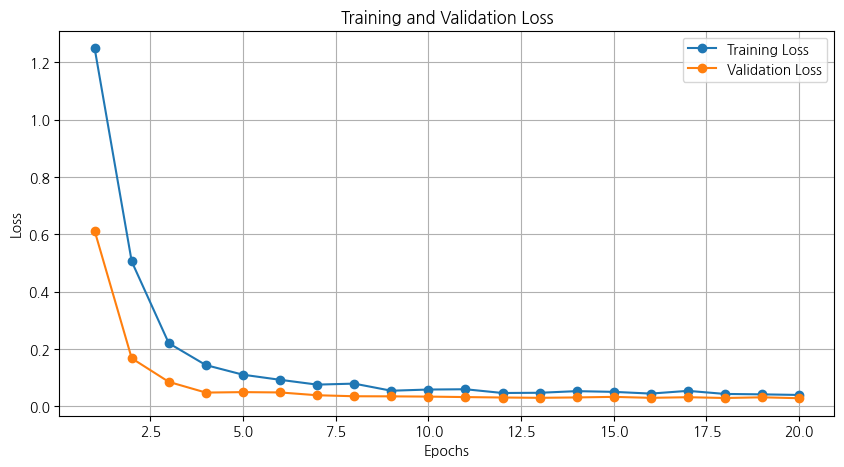

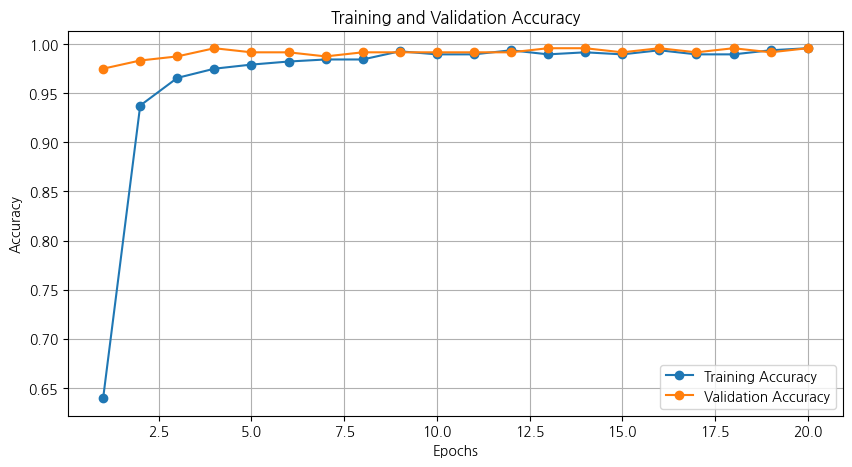

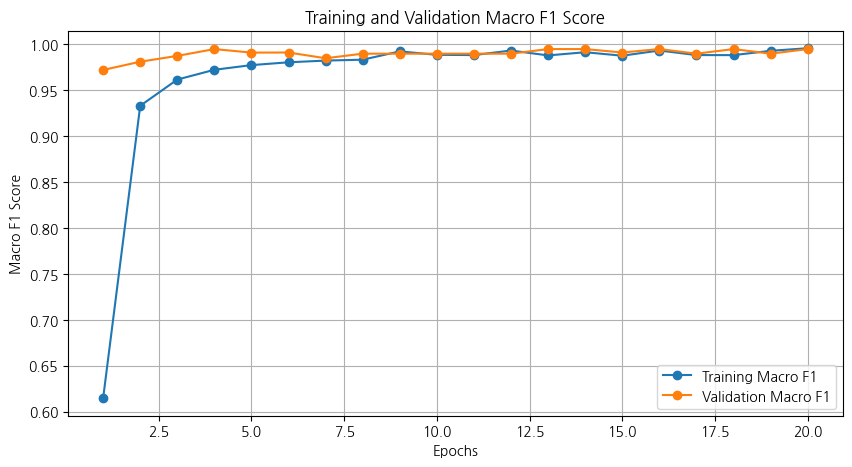

In [24]:
visualize_history(history2)

In [25]:
# OOM 방지를 위해 캐시된(cached) 메모리를 해제
torch.cuda.empty_cache()

In [26]:
early_stopping = EarlyStopping(patience=CFG["PATIENCE"], verbose=True, path="effi_s.pth")
# model 정의
model = timm.create_model(
    "hf_hub:timm/tf_efficientnetv2_s.in21k_ft_in1k",
    pretrained=True,
    num_classes=CFG["NUM_CLASSES"],
)
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8)

trained_model3, best_incorrect_samples3, history3 = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=CFG['DEVICE'],
    early_stopping=early_stopping
)

======== Training Start ========


Epoch 1/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/20
  Train Loss: 2.0338, Train Accuracy: 0.7531, Train Macro F1: 0.7377
  Val Loss: 0.4255, Val Accuracy: 0.9083, Val Macro F1: 0.9022
  >> New best model found! Macro F1: 0.9022. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 2/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/20
  Train Loss: 0.4048, Train Accuracy: 0.9219, Train Macro F1: 0.9183
  Val Loss: 0.1543, Val Accuracy: 0.9542, Val Macro F1: 0.9499
  >> New best model found! Macro F1: 0.9499. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 3/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/20
  Train Loss: 0.2718, Train Accuracy: 0.9417, Train Macro F1: 0.9388
  Val Loss: 0.1639, Val Accuracy: 0.9542, Val Macro F1: 0.9474
🔁 EarlyStopping counter: 1 / 20


Epoch 4/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/20
  Train Loss: 0.1555, Train Accuracy: 0.9563, Train Macro F1: 0.9541
  Val Loss: 0.1669, Val Accuracy: 0.9667, Val Macro F1: 0.9639
  >> New best model found! Macro F1: 0.9639. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 5/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/20
  Train Loss: 0.0884, Train Accuracy: 0.9760, Train Macro F1: 0.9729
  Val Loss: 0.1058, Val Accuracy: 0.9750, Val Macro F1: 0.9713
  >> New best model found! Macro F1: 0.9713. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 6/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/20
  Train Loss: 0.2301, Train Accuracy: 0.9542, Train Macro F1: 0.9516
  Val Loss: 0.1286, Val Accuracy: 0.9583, Val Macro F1: 0.9544
🔁 EarlyStopping counter: 1 / 20


Epoch 7/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/20
  Train Loss: 0.1446, Train Accuracy: 0.9656, Train Macro F1: 0.9630
  Val Loss: 0.1194, Val Accuracy: 0.9750, Val Macro F1: 0.9733
  >> New best model found! Macro F1: 0.9733. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 8/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/20
  Train Loss: 0.1326, Train Accuracy: 0.9688, Train Macro F1: 0.9669
  Val Loss: 0.1077, Val Accuracy: 0.9750, Val Macro F1: 0.9743
  >> New best model found! Macro F1: 0.9743. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 9/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/20
  Train Loss: 0.0860, Train Accuracy: 0.9781, Train Macro F1: 0.9769
  Val Loss: 0.0910, Val Accuracy: 0.9792, Val Macro F1: 0.9785
  >> New best model found! Macro F1: 0.9785. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 10/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/20
  Train Loss: 0.0722, Train Accuracy: 0.9802, Train Macro F1: 0.9781
  Val Loss: 0.1099, Val Accuracy: 0.9792, Val Macro F1: 0.9783
🔁 EarlyStopping counter: 1 / 20
  >> Saving checkpoint at epoch 10 to checkpoints/EfficientNet/checkpoint_epoch_10.pth...


Epoch 11/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/20
  Train Loss: 0.0819, Train Accuracy: 0.9802, Train Macro F1: 0.9796
  Val Loss: 0.0924, Val Accuracy: 0.9833, Val Macro F1: 0.9812
  >> New best model found! Macro F1: 0.9812. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 12/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/20
  Train Loss: 0.0782, Train Accuracy: 0.9802, Train Macro F1: 0.9782
  Val Loss: 0.0991, Val Accuracy: 0.9792, Val Macro F1: 0.9773
🔁 EarlyStopping counter: 1 / 20


Epoch 13/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/20
  Train Loss: 0.0863, Train Accuracy: 0.9812, Train Macro F1: 0.9803
  Val Loss: 0.0897, Val Accuracy: 0.9875, Val Macro F1: 0.9850
  >> New best model found! Macro F1: 0.9850. Updating incorrect samples list.
F1 score improved. Saving model to effi_s.pth


Epoch 14/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/20
  Train Loss: 0.0361, Train Accuracy: 0.9896, Train Macro F1: 0.9887
  Val Loss: 0.0939, Val Accuracy: 0.9750, Val Macro F1: 0.9721
🔁 EarlyStopping counter: 1 / 20


Epoch 15/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/20
  Train Loss: 0.0449, Train Accuracy: 0.9885, Train Macro F1: 0.9875
  Val Loss: 0.0986, Val Accuracy: 0.9833, Val Macro F1: 0.9812
🔁 EarlyStopping counter: 2 / 20


Epoch 16/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/20
  Train Loss: 0.0355, Train Accuracy: 0.9885, Train Macro F1: 0.9878
  Val Loss: 0.0914, Val Accuracy: 0.9792, Val Macro F1: 0.9773
🔁 EarlyStopping counter: 3 / 20


Epoch 17/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/20
  Train Loss: 0.0594, Train Accuracy: 0.9854, Train Macro F1: 0.9844
  Val Loss: 0.0880, Val Accuracy: 0.9833, Val Macro F1: 0.9800
🔁 EarlyStopping counter: 4 / 20


Epoch 18/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/20
  Train Loss: 0.0417, Train Accuracy: 0.9854, Train Macro F1: 0.9841
  Val Loss: 0.1016, Val Accuracy: 0.9833, Val Macro F1: 0.9800
🔁 EarlyStopping counter: 5 / 20


Epoch 19/20 Training:   0%|          | 0/60 [00:10<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/20
  Train Loss: 0.0440, Train Accuracy: 0.9906, Train Macro F1: 0.9903
  Val Loss: 0.0929, Val Accuracy: 0.9833, Val Macro F1: 0.9812
🔁 EarlyStopping counter: 6 / 20


Epoch 20/20 Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/20
  Train Loss: 0.0421, Train Accuracy: 0.9896, Train Macro F1: 0.9884
  Val Loss: 0.0852, Val Accuracy: 0.9833, Val Macro F1: 0.9812
🔁 EarlyStopping counter: 7 / 20
  >> Saving checkpoint at epoch 20 to checkpoints/EfficientNet/checkpoint_epoch_20.pth...
======== Training Finished ========
Loading best model weights from: effi_s.pth


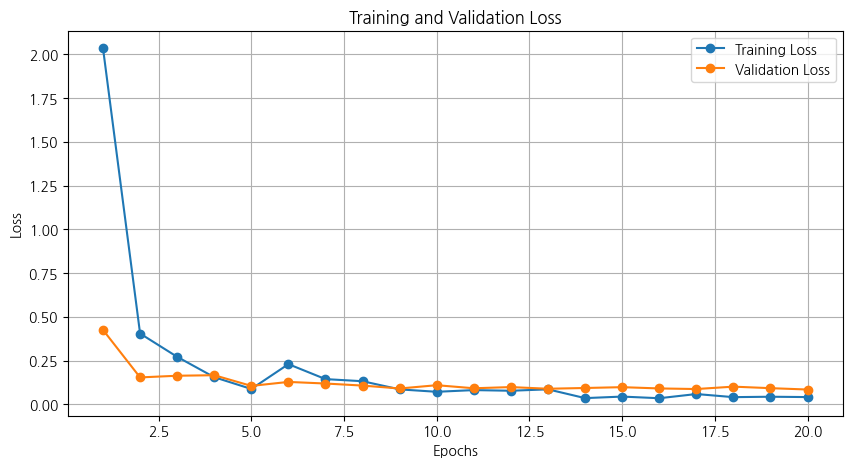

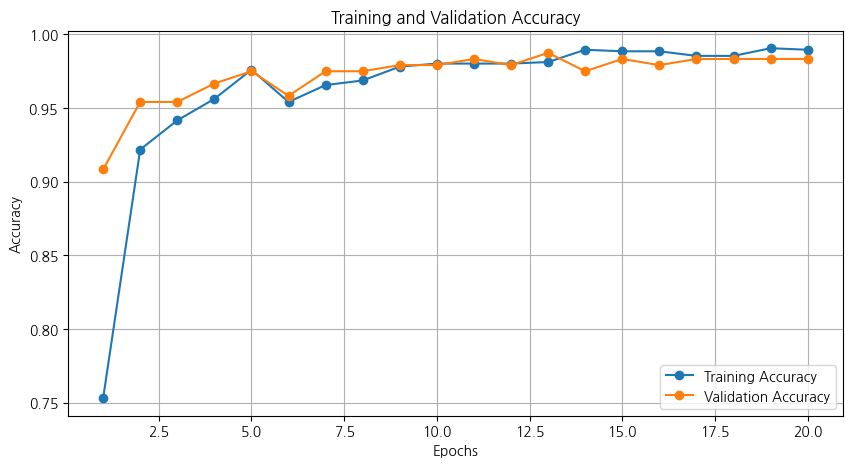

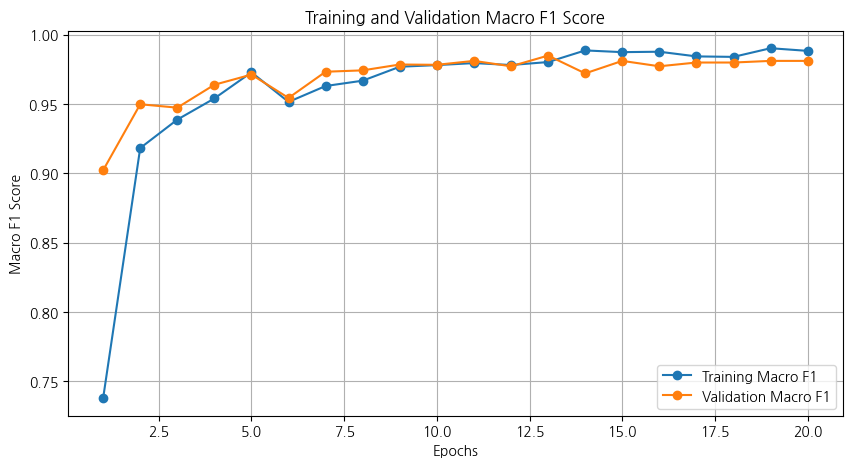

In [27]:
visualize_history(history3)

## 모델 평가 및 결과 저장

In [22]:
# 학습 완료된 모델 불러오기
model1 = timm.create_model(
    "hf_hub:timm/tiny_vit_21m_384.dist_in22k_ft_in1k",
    pretrained=False
)
model1.reset_classifier(num_classes=CFG["NUM_CLASSES"])
model1.to(CFG['DEVICE'])
model1.load_state_dict(torch.load('./tiny_vit384.pth', map_location=CFG['DEVICE']))

model2 = timm.create_model(
    "hf_hub:timm/tf_efficientnetv2_s.in21k_ft_in1k",
    pretrained=False
)
model2.reset_classifier(num_classes=CFG["NUM_CLASSES"])
model2.to(CFG['DEVICE'])
model2.load_state_dict(torch.load('./effi_s.pth', map_location=CFG['DEVICE']))

model3 = timm.create_model(
    "hf_hub:timm/regnety_120.sw_in12k_ft_in1k",
    pretrained=False
)
model3.reset_classifier(num_classes=CFG["NUM_CLASSES"])
model3.to(CFG['DEVICE'])
model3.load_state_dict(torch.load('./regnety_120.pth', map_location=CFG['DEVICE']))

<All keys matched successfully>

In [23]:
class_names = unique_labels
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def unnormalize(tensor, mean, std):
    """
    정규화된 텐서를 원래 값으로 되돌립니다
    
    Args:
        tensor: 정규화된 텐서
        mean: 평균값
        std: 표준편차
        
    Returns:
        tensor: 정규화 해제된 텐서
    """
    
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_incorrect_predictions(incorrect_samples, num_images=20):
    """
    잘못 예측된 샘플들을 시각화합니다
    
    Args:
        incorrect_samples: 잘못 예측된 샘플들
        num_images (int): 보여줄 이미지 수
    """

    if not incorrect_samples:
        print("틀린 예측이 없습니다!")
        return
        
    print(f"총 {len(incorrect_samples)}개의 틀린 예측 중, 최대 {num_images}개를 표시합니다.")
    num_images = min(num_images, len(incorrect_samples))
    
    # 이미지 표시에 적절한 행과 열 계산
    cols = 4
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten() # 2D 배열을 1D로 만듦

    for i, sample in enumerate(incorrect_samples[:num_images]):
        img_tensor = sample['image']
        true_label_idx = sample['true_label']
        pred_label_idx = sample['pred_label']
        
        # 이미지 정규화 해제
        img = unnormalize(img_tensor.clone(), MEAN, STD)
        
        # Tensor를 numpy 배열로 변환 (C, H, W) -> (H, W, C)
        img = img.permute(1, 2, 0).numpy()
        
        ax = axes[i]
        ax.imshow(img)
        true_label_name = class_names[true_label_idx] if true_label_idx < len(class_names) else 'N/A'
        pred_label_name = class_names[pred_label_idx] if pred_label_idx < len(class_names) else 'N/A'
        
        ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color='red')
        ax.axis('off')

    # 남는 subplot 숨기기
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [24]:
_, _, _, incorrect_samples1 = validation(model1, nn.CrossEntropyLoss(), val_loader, CFG['DEVICE'])
_, _, _, incorrect_samples2 = validation(model2, nn.CrossEntropyLoss(), val_loader, CFG['DEVICE'])
_, _, _, incorrect_samples3 = validation(model3, nn.CrossEntropyLoss(), val_loader, CFG['DEVICE'])

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

총 1개의 틀린 예측 중, 최대 20개를 표시합니다.


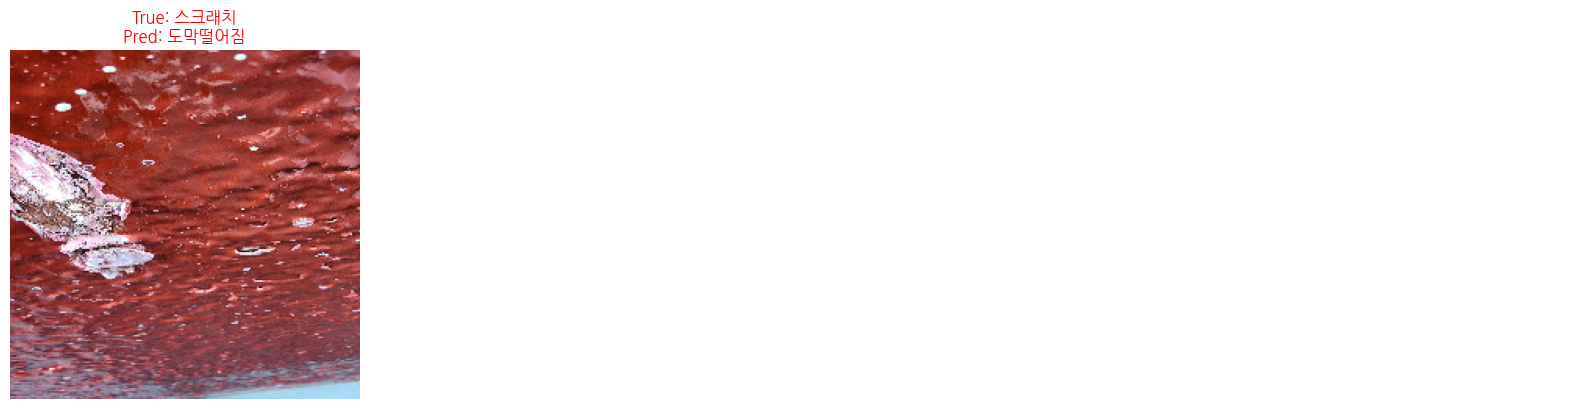

In [25]:
show_incorrect_predictions(incorrect_samples1, num_images=20)

총 3개의 틀린 예측 중, 최대 20개를 표시합니다.


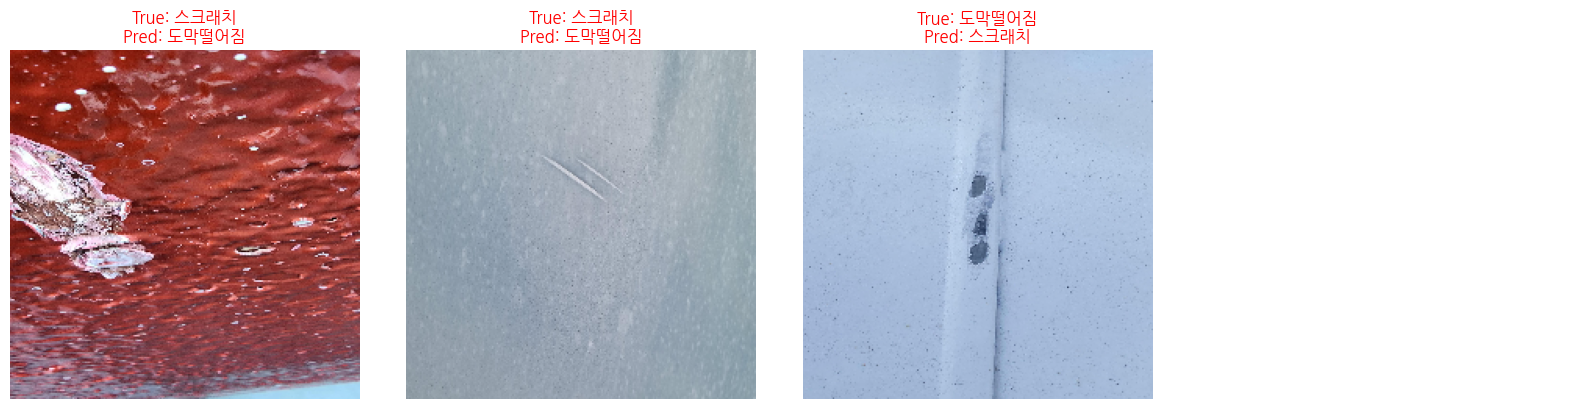

In [26]:
show_incorrect_predictions(incorrect_samples2, num_images=20)

총 1개의 틀린 예측 중, 최대 20개를 표시합니다.


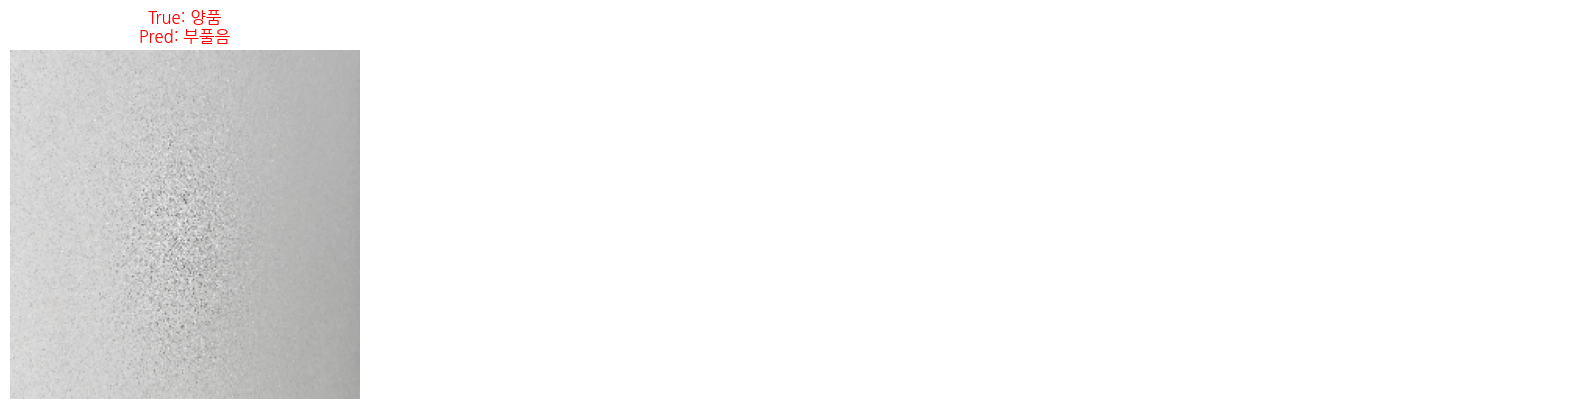

In [27]:
show_incorrect_predictions(incorrect_samples3, num_images=20)

In [28]:
# --- 1. 기하학적 TTA 함수  ---
def apply_geometric_tta(imgs):
    """
    기하학적 테스트 시간 증강(Test Time Augmentation)을 적용합니다
    
    Args:
        imgs: 입력 이미지들
        
    Returns:
        list: 증강된 이미지 리스트
    """

    tta_list = [
        imgs,
        torch.flip(imgs, dims=[3]),  # 좌우 반전
        torch.flip(imgs, dims=[2]),  # 상하 반전
        torch.rot90(imgs, k=1, dims=[2, 3]),
        torch.rot90(imgs, k=2, dims=[2, 3]),
        torch.rot90(imgs, k=3, dims=[2, 3]),
        torch.transpose(imgs, 2, 3),
    ]
    return torch.cat(tta_list, dim=0)

# --- 2. 멀티스케일 TTA를 적용하는 함수 ---
def apply_multiscale_tta(imgs, scales, target_size):
    """
    다중 스케일 TTA 적용합니다
    
    Args:
        imgs: 입력 이미지들
        scales (list): 적용할 스케일 리스트
        target_size (tuple): 목표 이미지 크기
        
    Returns:
        list: 증강된 이미지 리스트
    """
    all_tta_batches = []
    
    for scale in scales:
        # 1. 스케일에 맞춰 이미지 크기 조절
        # antialias=True는 이미지 품질 저하를 막아주는 옵션입니다.
        scaled_imgs = F.resize(imgs, size=[int(target_size * scale), int(target_size * scale)], antialias=True)
        
        # 2. 모델 입력 크기에 맞게 중앙을 잘라냄 (Center Crop)
        cropped_imgs = F.center_crop(scaled_imgs, output_size=[target_size, target_size])
        
        # 3. 스케일이 적용된 이미지에 7가지 기하학적 TTA 적용
        geometric_tta_batch = apply_geometric_tta(cropped_imgs)
        all_tta_batches.append(geometric_tta_batch)
        
    return torch.cat(all_tta_batches, dim=0)

# --- 3. 최종 TTA 추론 및 확률 계산 함수 ---
def get_tta_probs(model, loader, device, scales, target_size):
    """
    다중 스케일 테스트 시간 증강을 적용합니다
    
    Args:
        imgs: 입력 이미지들
        scales (list): 적용할 스케일 리스트
        target_size (tuple): 목표 이미지 크기
        
    Returns:
        list: 증강된 이미지 리스트
    """
    model.eval()
    all_probs = []
    
    # 기하학적 TTA 개수는 7개로 고정
    geometric_tta_count = 7
    # 전체 TTA 개수는 스케일 수 * 기하학적 TTA 수
    total_tta_count = len(scales) * geometric_tta_count

    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc=f"Inference with {len(scales)} Scales TTA"):
            imgs = imgs.to(device)
            
            original_batch_size = imgs.shape[0]

            # 1. 멀티스케일 TTA가 적용된 모든 이미지 배치를 한 번에 생성
            # shape: (배치크기 * 스케일 수 * 7, C, H, W)
            imgs_tta = apply_multiscale_tta(imgs, scales=scales, target_size=target_size)
            
            # 2. 모든 TTA 이미지를 모델에 전달
            preds = model(imgs_tta)
            
            # 3. 예측 결과를 TTA별로 분리하고 평균 계산
            # (배치크기 * total_tta_count, 클래스 수) -> (total_tta_count, 배치크기, 클래스 수)
            num_classes = preds.shape[1]
            preds_view = preds.view(total_tta_count, original_batch_size, num_classes)
            
            # 모든 TTA 결과의 평균 logits 계산
            avg_preds = preds_view.mean(0) # shape: (배치크기, 클래스 수)
            
            # 확률 값으로 변환 (Softmax)
            probs = avg_preds.softmax(1)
            all_probs.append(probs.cpu().numpy())
            
    final_probs = np.concatenate(all_probs, axis=0)
    return final_probs

In [29]:
# 테스트 데이터셋 준비
TEST_ROOT = CFG["ROOT"] / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 테스트 이미지 경로 수집
test_image_paths = []
for p in TEST_ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        test_image_paths.append(str(p))

#  파일명을 기준으로 경로를 정렬하여 일관된 순서 유지
test_image_paths = sorted(test_image_paths, key=lambda x: Path(x).name)

# 테스트 데이터셋을 위한 임시 라벨 리스트 생성 (추론 시에는 실제 라벨이 없음)
# 추론에는 이미지 경로만 필요함
test_labels_dummy = [None] * len(test_image_paths)

# 검증용 transform을 사용하여 테스트 데이터셋 생성
test_dataset = ShipDefectDataset(
    image_paths=test_image_paths,
    labels=test_labels_dummy, # 더미 라벨
    class_to_idx=class_to_idx, 
    transform=val_transform, # validation transform 사용
)


# 테스트 데이터로더 생성
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=False, 
)

print(f"✅ {len(test_image_paths)}개의 이미지로 테스트 데이터셋 준비 완료.")

✅ 1000개의 이미지로 테스트 데이터셋 준비 완료.


### 메모리 한계로 인한 엔비디아 오류 발생 시
:RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1016, please report a bug to PyTorch. 
1. Kernel Restart 한 뒤 모델 학습만 생략하고 나머지 셀을 실행한다.
2. 저장된 .pth로부터 모델 가중치를 가져와 TTA, 추론 코드가 정상 작동한다.

In [30]:
!nvidia-smi

Wed Aug 20 02:55:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:17:00.0 Off |                   On |
| N/A   37C    P0              73W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [31]:
# OOM 방지를 위해 캐시된(cached) 메모리를 해제
torch.cuda.empty_cache()

In [32]:
SCALES = [1.0, 1.2]  # 100%, 120% 크기로 테스트

probs1 = get_tta_probs(model1, test_loader, CFG['DEVICE'],scales=SCALES,target_size=CFG['IMG_SIZE'])
probs2 = get_tta_probs(model2, test_loader, CFG['DEVICE'],scales=SCALES,target_size=CFG['IMG_SIZE'])
probs3 = get_tta_probs(model3, test_loader, CFG['DEVICE'],scales=SCALES,target_size=CFG['IMG_SIZE'])


weighted_probs = probs1 + probs2 + probs3 
final_preds = np.argmax(weighted_probs, axis=1)

Inference with 2 Scales TTA:   0%|          | 0/63 [00:00<?, ?it/s]

Inference with 2 Scales TTA:   0%|          | 0/63 [00:00<?, ?it/s]

Inference with 2 Scales TTA:   0%|          | 0/63 [00:00<?, ?it/s]

In [33]:
# 예측 결과 처리
# 예측된 인덱스를 다시 클래스 이름으로 변환
idx_to_class = {idx: label for label, idx in class_to_idx.items()}
predicted_class_names = [idx_to_class[pred] for pred in final_preds]

# '양품선'과 '양품외'를 '양품'으로 통합
processed_labels = ["양품" if label in ["양품선", "양품외"] else label for label in predicted_class_names]

print("✅ 예측 결과 처리 완료.")

✅ 예측 결과 처리 완료.


In [34]:
# 제출 파일 생성
# pandas DataFrame 생성
test_filenames = []
test_filenames = [Path(p).name for p in test_image_paths]
df_submit = pd.DataFrame({"label": processed_labels}, index=test_filenames)

# 일관성을 위해 파일명으로 인덱스 정렬
df_submit = df_submit.sort_index()

# 제출 파일 저장
submission_path = "./submission.csv"
df_submit.to_csv(submission_path, encoding="utf-8")

print(f"✅ 제출 파일이 {submission_path}에 저장되었습니다.")
display(df_submit.head())

✅ 제출 파일이 ./submission.csv에 저장되었습니다.


label
00001.jpg  도막떨어짐
00002.jpg  도막떨어짐
00003.jpg   스크래치
00004.jpg   스크래치
00005.jpg     양품

### 예측값 분포 확인

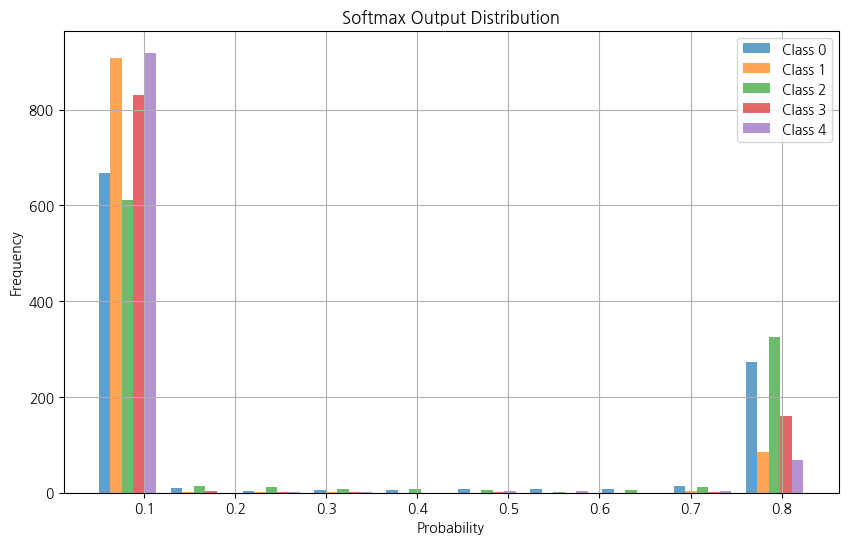

In [35]:
# Softmax 적용을 위해 NumPy array를 PyTorch tensor로 변경
weighted_probs_tensor = torch.from_numpy(weighted_probs)

# Softmax 적용
softmax_output = nn.functional.softmax(weighted_probs_tensor, dim=1)

# 시각화를 위해 PyTorch tensor를 NumPy array로 변경
softmax_np = softmax_output.numpy()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(softmax_np, bins=10, label=[f'Class {i}' for i in range(softmax_np.shape[1])], alpha=0.7)
plt.title('Softmax Output Distribution')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

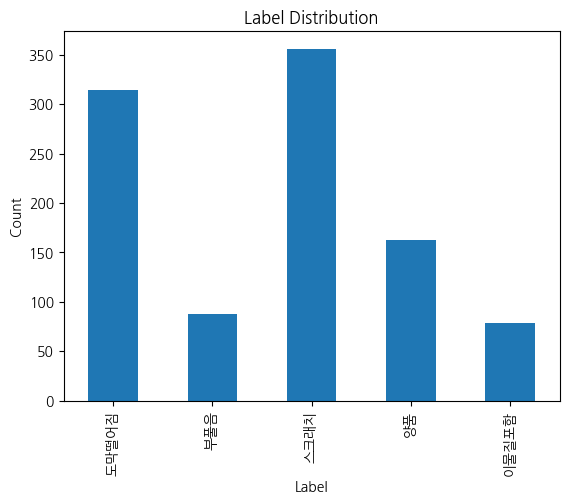

In [36]:
df_submit['label'].value_counts().sort_index().plot(kind='bar')

# 히스토그램 제목과 축 레이블 설정
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()

In [37]:
df_submit['label'].value_counts().sort_index()

label
도막떨어짐    314
부풀음       88
스크래치     356
양품       163
이물질포함     79
Name: count, dtype: int64

## 제출 결과 : 0.98135

In [38]:
CFG

{'ROOT': PosixPath('/mnt/elice/dataset'),
 'SEED': 42,
 'DEVICE': device(type='cuda'),
 'IMG_SIZE': 224,
 'EPOCHS': 20,
 'PATIENCE': 20,
 'LEARNING_RATE': 0.0001,
 'BATCH_SIZE': 16,
 'NUM_CLASSES': 5}